# Relationship between item reactivation and semantic integration

In [1]:
import os
from pathlib import Path
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from mindstorm import statplot
from bender_study import rsa
from bender_study import task

bids_dir = Path(os.environ['BENDER_BIDS']) / 'rawdata'
res_dir = Path(os.environ['BENDER_RESULTS'])
fig_dir = Path(os.environ['BENDER_FIGURES']) / 'plots'

rdm_dir = res_dir / 'batch' / 'glm' / 'study_stim2'
model_file = res_dir / 'batch' / 'semantics' / 'wiki_w2v.npz'

## Load behavioral study phase data

In [2]:
subjects = task.get_subjects('react')
dfs = [
    (
        task.load_merged_study_events(bids_dir, s)
        .sort_values('group')
        .query('pair_type == "BC"')
    ) for s in subjects
]

## Load model of semantic similarity

In [3]:
model = np.load(model_file)

## Load neural RDMs

In [4]:
# load the pre-exposure to study representational 
# dissimilarity matrix for each ROI and subject
suffix = 'dil1c'

# pre-exposure to study pattern similarity for potential control region
item_rois = ['amPFC']
item_clusters = ['ampfc']
item_analyses = ['cat_react_item_sme2']
item_rdms = rsa.load_roi_rdms(
    rdm_dir / 'react', subjects, item_rois, item_analyses, item_clusters, suffix
)

# study pattern similarity for ROIs that correlate with semantic integration model
integ_rois = ['aHPC', 'RPRC']
integ_clusters = ['rhpc', 'rprc']
integ_analyses = [
    'study_wiki_w2v_fix_cont_ac_bx_sme', 'study_wiki_w2v_fix_cont_ac_bx_sme'
]
integ_rdms = rsa.load_roi_rdms(
    rdm_dir / 'rdm', subjects, integ_rois, integ_analyses, integ_clusters, suffix
)

## Relationship between item suppression and integration

In [5]:
results = rsa.item_model_correlation(subjects, item_rdms, integ_rdms, dfs, model)

acc = results.set_index(['correct', 'subject', 'item_roi', 'integ_roi'])
sme = acc.loc[1] - acc.loc[0]

### Incorrect trials

In [6]:
groups = acc.loc[0].groupby(['item_roi', 'integ_roi'])['slope']
groups.agg(['mean', 'sem'])

mean       sem
item_roi integ_roi                    
amPFC    RPRC      -0.053663  0.043923
         aHPC       0.160530  0.070378

In [7]:
groups.apply(pg.ttest, 0)

T  dof alternative     p-val          CI95%  \
item_roi integ_roi                                                              
amPFC    RPRC      T-test -1.221745   28   two-sided  0.231991  [-0.14, 0.04]   
         aHPC      T-test  2.280966   28   two-sided  0.030360    [0.02, 0.3]   

                            cohen-d   BF10     power  
item_roi integ_roi                                    
amPFC    RPRC      T-test  0.226872  0.387  0.218579  
         aHPC      T-test  0.423565   1.81  0.595754

In [8]:
groups.apply(pg.wilcoxon, np.zeros(len(subjects)))

W-val alternative     p-val       RBC      CLES
item_roi integ_roi                                                          
amPFC    RPRC      Wilcoxon  148.0   two-sided  0.135699 -0.319540  0.344828
         aHPC      Wilcoxon  111.0   two-sided  0.021902  0.489655  0.655172

### Correct trials

In [9]:
groups = acc.loc[1].groupby(['item_roi', 'integ_roi'])['slope']
groups.agg(['mean', 'sem'])

mean       sem
item_roi integ_roi                    
amPFC    RPRC       0.004289  0.004902
         aHPC      -0.005582  0.006877

In [10]:
groups.apply(pg.ttest, 0)

T  dof alternative     p-val          CI95%  \
item_roi integ_roi                                                              
amPFC    RPRC      T-test  0.875013   29   two-sided  0.388757  [-0.01, 0.01]   
         aHPC      T-test -0.811664   29   two-sided  0.423597  [-0.02, 0.01]   

                            cohen-d   BF10     power  
item_roi integ_roi                                    
amPFC    RPRC      T-test  0.159755  0.276  0.135218  
         aHPC      T-test  0.148189  0.263  0.123039

In [11]:
groups.apply(pg.wilcoxon, np.zeros(len(subjects)))

W-val alternative     p-val       RBC  CLES
item_roi integ_roi                                                      
amPFC    RPRC      Wilcoxon  188.0   two-sided  0.365462  0.191398   0.5
         aHPC      Wilcoxon  190.0   two-sided  0.387659 -0.182796   0.4

### Subsequent memory effect

In [12]:
groups = sme.groupby(['item_roi', 'integ_roi'])['slope']
groups.agg(['mean', 'sem'])

mean       sem
item_roi integ_roi                    
amPFC    RPRC       0.057557  0.044828
         aHPC      -0.166306  0.070481

In [13]:
groups.apply(pg.ttest, 0)

T  dof alternative     p-val  \
item_roi integ_roi                                               
amPFC    RPRC      T-test  1.283946   28   two-sided  0.209684   
         aHPC      T-test -2.359570   28   two-sided  0.025502   

                                    CI95%   cohen-d   BF10     power  
item_roi integ_roi                                                    
amPFC    RPRC      T-test   [-0.03, 0.15]  0.238423  0.415  0.236506  
         aHPC      T-test  [-0.31, -0.02]  0.438161  2.087  0.624827

In [14]:
groups.apply(pg.wilcoxon, np.zeros(len(subjects)))

W-val alternative     p-val       RBC      CLES
item_roi integ_roi                                                          
amPFC    RPRC      Wilcoxon  157.0   two-sided  0.194496  0.278161  0.586207
         aHPC      Wilcoxon  101.0   two-sided  0.012132 -0.535632  0.379310

### Plot correlation by ROI and accuracy

In [15]:
dark = sns.color_palette(
    [
        (1.0000, 0.2784, 0.5647),
        (0.4000, 0.4000, 0.4000),
    ]
)
light = sns.color_palette(
    [
        (1.0000, 0.5961, 0.8275),
        (0.8000, 0.8000, 0.8000),
    ]
)

LINO NOT subset; don't know how to subset; dropped


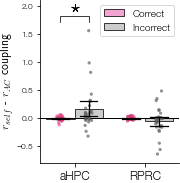

In [16]:
m = acc.reset_index().query('item_roi == "amPFC"')
m['Inference'] = m['correct'].map({0: 'Incorrect', 1: 'Correct'})

fig, ax = plt.subplots(figsize=(2.5, 3))
ax.set(ylim=(-0.8, 2.1))
ax = statplot.plot_swarm_bar(
    data=m, 
    x='integ_roi', 
    y='slope', 
    hue='Inference',
    hue_order=['Correct', 'Incorrect'],
    dodge=True,
    bar_kws=dict(capsize=.25),
    light=light,
    dark=dark,
    point_kind='strip',
    sig_diff_ind=[[0, 1]],
    ax=ax,
)

xlim = ax.get_xlim()
ax.hlines(0, *xlim, colors=['k']);
ax.set(xlim=xlim, ylabel='$r_(self)$ – $r_(AC)$ coupling');
ax.set_ylabel('$r_{self}$ - $r_{AC}$ coupling', usetex=True)

fig.savefig(fig_dir / 'cluster_react_sem.pdf')

In [17]:
dark = sns.color_palette(
    [
        (0.7000, 0.7000, 0.7000),
        (0.4000, 0.4000, 0.4000),
    ]
)
light = sns.color_palette(
    [
        (0.9000, 0.9000, 0.9000),
        (0.6000, 0.6000, 0.6000),
    ]
)
dark

[(0.7, 0.7, 0.7), (0.4, 0.4, 0.4)]

In [18]:
light

[(0.9, 0.9, 0.9), (0.6, 0.6, 0.6)]

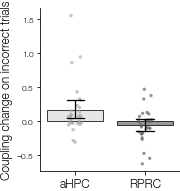

In [19]:
fig, ax = plt.subplots(figsize=(2.5, 3))
ax = statplot.plot_swarm_bar(
    data=-sme, 
    x='integ_roi', 
    y='slope', 
    dodge=True,
    bar_kws=dict(capsize=.25),
    light=light,
    dark=dark,
    point_kind='strip',
    ax=ax,
)
ax.set(ylabel='Coupling change on incorrect trials');

In [21]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

numpy       : 1.22.3
mindstorm   : 0.9.0
matplotlib  : 3.5.1
pingouin    : 0.5.2
seaborn     : 0.11.2
bender_study: 0.1.0

